In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path
import torch
import pickle
import matplotlib.pyplot as plt

from torcheval.metrics import BinaryF1Score, BinaryAccuracy
from torch.utils.data.sampler import SubsetRandomSampler
from dgl.dataloading import GraphDataLoader

from src.net import InstanceGCN
from src.utils import load_from_wandb
from src.dataset import JobFeasibilityDataset, SatelliteFeasibilityDataset

# Feasibility

# Job

In [3]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import HeteroGraphConv, GraphConv, EGATConv, SAGEConv


class ExplainableInstanceGCN(InstanceGCN):
    """Suitable for HeteroGNNExplainer.
    """
    def forward(self, graph, feat, eweight=None):
        with graph.local_scope():
            graph.ndata['x'] = feat
            if eweight is not None:
                graph.edata['A'] = eweight

            return super().forward(graph)


net = ExplainableInstanceGCN(2,)
net = load_from_wandb(net, 'gebp7q0y', 'sat-gnn', 'model_best')

from dgl.nn.pytorch.explain import HeteroGNNExplainer

data = JobFeasibilityDataset('../data/raw/97_9.jl')

feat_importances = list()
edge_importances = list()
ys = list()
for i in range(8000, 8002):
    g, y = data[i]

    explainer = HeteroGNNExplainer(net, 2, )
    feat = g.ndata['x']
    feat['soc'] = torch.zeros((0,0)).to(feat['soc'].unsqueeze(0))

    feat_importance, edge_importance = explainer.explain_graph(g, feat)
    feat_importances.append(feat_importance)
    edge_importances.append(edge_importance)
    ys.append(y)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


Explain graph: 100%|██████████| 100/100 [00:00<00:00, 109.51it/s]


In [70]:
from src.problem import get_model

m = get_model([8,], '../data/raw/97_9.jl', coupling=False)
m.update()
m.getVars()

[<gurobi.Var x(8,0)>,
 <gurobi.Var x(8,1)>,
 <gurobi.Var x(8,2)>,
 <gurobi.Var x(8,3)>,
 <gurobi.Var x(8,4)>,
 <gurobi.Var x(8,5)>,
 <gurobi.Var x(8,6)>,
 <gurobi.Var x(8,7)>,
 <gurobi.Var x(8,8)>,
 <gurobi.Var x(8,9)>,
 <gurobi.Var x(8,10)>,
 <gurobi.Var x(8,11)>,
 <gurobi.Var x(8,12)>,
 <gurobi.Var x(8,13)>,
 <gurobi.Var x(8,14)>,
 <gurobi.Var x(8,15)>,
 <gurobi.Var x(8,16)>,
 <gurobi.Var x(8,17)>,
 <gurobi.Var x(8,18)>,
 <gurobi.Var x(8,19)>,
 <gurobi.Var x(8,20)>,
 <gurobi.Var x(8,21)>,
 <gurobi.Var x(8,22)>,
 <gurobi.Var x(8,23)>,
 <gurobi.Var x(8,24)>,
 <gurobi.Var x(8,25)>,
 <gurobi.Var x(8,26)>,
 <gurobi.Var x(8,27)>,
 <gurobi.Var x(8,28)>,
 <gurobi.Var x(8,29)>,
 <gurobi.Var x(8,30)>,
 <gurobi.Var x(8,31)>,
 <gurobi.Var x(8,32)>,
 <gurobi.Var x(8,33)>,
 <gurobi.Var x(8,34)>,
 <gurobi.Var x(8,35)>,
 <gurobi.Var x(8,36)>,
 <gurobi.Var x(8,37)>,
 <gurobi.Var x(8,38)>,
 <gurobi.Var x(8,39)>,
 <gurobi.Var x(8,40)>,
 <gurobi.Var x(8,41)>,
 <gurobi.Var x(8,42)>,
 <gurobi.Var x(8,43)>

In [7]:
net.readout_op = None
logits = list()
for i in range(8000, 8002):
    g, y = data[i]

    with torch.no_grad():
        logits.append(InstanceGCN.forward(net, g)[0])
len(logits)

2

In [8]:
torch.stack(logits).shape

torch.Size([2, 194])

In [26]:
edge_importances[1][('var', 'v2c', 'con')].shape

torch.Size([7160])

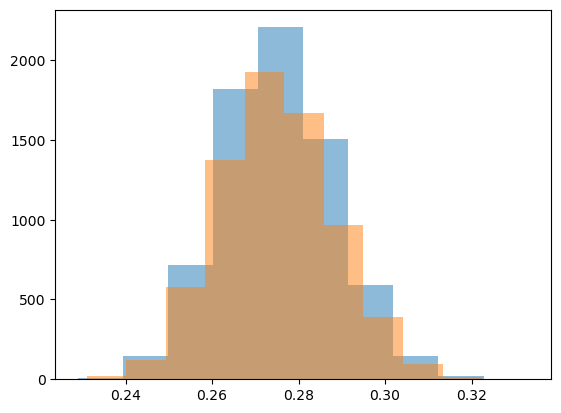

In [23]:
plt.hist(edge_importance[('var', 'v2c', 'con')], alpha=0.5)
plt.hist(edge_importance[('con', 'c2v', 'var')], alpha=0.5)
plt.show()

In [13]:
with open('../exp1_feat_importances.pkl', 'rb') as f:
    feat_importances = pickle.load(f)

con_importances = feat_importances['con']
var_importances = feat_importances['var']
c2v_importances = feat_importances['c2v']
v2c_importances = feat_importances['v2c']
ys = feat_importances['y']
logits = feat_importances['logits'].detach()

c2v_importances.shape

torch.Size([1000, 7160])

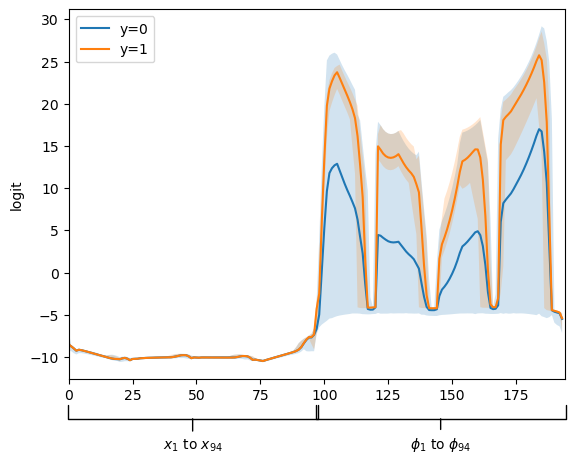

In [52]:
plt.plot(logits[ys==0].mean(0), label='y=0')
# plt.fill_between(list(range(194)), logits[ys==0].quantile(0.05, 0), logits[ys==0].quantile(0.95, 0), alpha=0.5)
plt.fill_between(list(range(194)), logits[ys==0].min(0).values, logits[ys==0].max(0).values, alpha=0.2)
plt.plot(logits[ys==1].mean(0), label='y=1')
# plt.fill_between(list(range(194)), logits[ys==1].quantile(0.05, 0), logits[ys==1].quantile(0.95, 0), alpha=0.5)
plt.fill_between(list(range(194)), logits[ys==1].min(0).values, logits[ys==1].max(0).values, alpha=0.2)
plt.legend()
plt.ylabel('logit')
plt.xlim(0,194)
plt.annotate('$x_1$ to $x_{97}$', xy=(0.25, -0.1), xytext=(0.25, -0.2),
             xycoords='axes fraction', ha='center', va='bottom',
             arrowprops=dict(arrowstyle='-[, widthB=9.0, lengthB=1.0', lw=1.0))
plt.annotate('$\phi_1$ to $\phi_{97}$', xy=(0.75, -0.1), xytext=(0.75, -0.2),
             xycoords='axes fraction', ha='center', va='bottom',
             arrowprops=dict(arrowstyle='-[, widthB=9.0, lengthB=1.0', lw=1.0))
plt.show()

[]

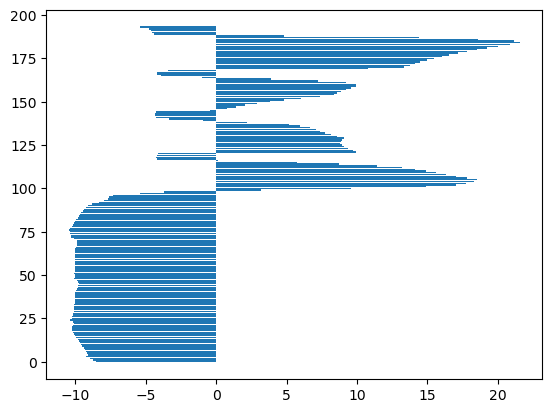

In [17]:
plt.barh(list(range(194)), logits.mean(0))
plt.plot()

(array([1.600e+01, 1.240e+02, 6.420e+02, 1.685e+03, 2.289e+03, 1.600e+03,
        6.510e+02, 1.360e+02, 1.600e+01, 1.000e+00]),
 array([0.27333406, 0.27366778, 0.27400151, 0.27433524, 0.27466896,
        0.27500266, 0.27533638, 0.27567011, 0.27600384, 0.27633756,
        0.27667129]),
 <BarContainer object of 10 artists>)

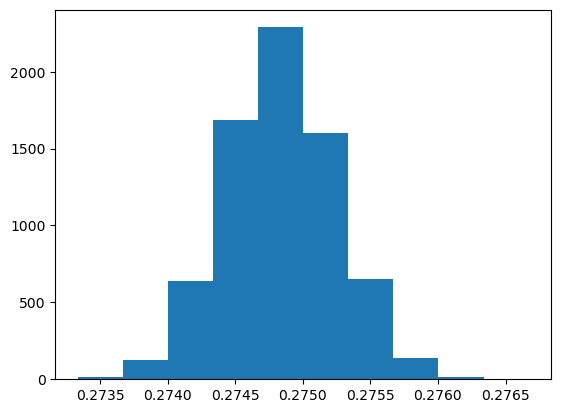

In [30]:
plt.hist(v2c_importances.mean(0))

In [27]:
con_importances[ys > .5].mean(0), con_importances[ys < .5].mean(0)

(tensor([0.2730, 0.2734]), tensor([0.2733, 0.2728]))

In [28]:
var_importances[ys > .5].mean(0), var_importances[ys < .5].mean(0)

(tensor([0.2717, 0.2733]), tensor([0.2722, 0.2737]))

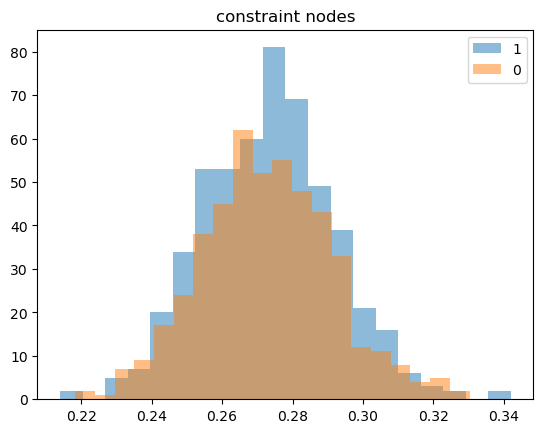

In [37]:
import matplotlib.pyplot as plt

plt.hist(con_importances[ys>0.5][:,1], alpha=0.5, label='1', bins=20)
plt.hist(con_importances[ys<0.5][:,1], alpha=0.5, label='0', bins=20)
plt.title('constraint nodes')
plt.legend()
plt.show()

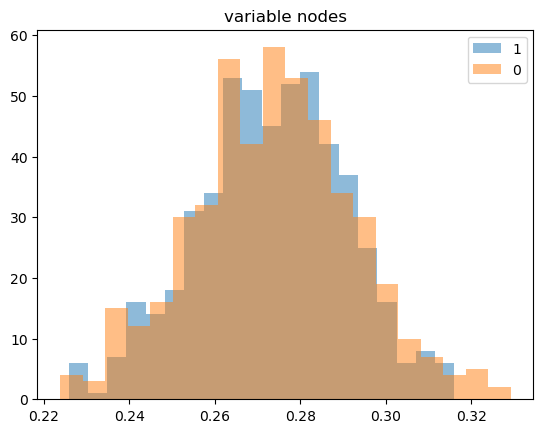

In [38]:
plt.hist(var_importances[ys>0.5][:,1], alpha=0.5, label='1', bins=20)
plt.hist(var_importances[ys<0.5][:,1], alpha=0.5, label='0', bins=20)
plt.title('variable nodes')
plt.legend()
plt.show()

## ONTS

In [60]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import HeteroGraphConv, GraphConv, EGATConv, SAGEConv


class ExplainableInstanceGCN(InstanceGCN):
    """Suitable for HeteroGNNExplainer.
    """
    def forward(self, graph, feat, eweight=None):
        with graph.local_scope():
            graph.ndata['x'] = feat
            if eweight is not None:
                graph.edata['A'] = eweight

            return super().forward(graph)


net = ExplainableInstanceGCN(2,)
net = load_from_wandb(net, '12arvgxb', 'sat-gnn', 'model_best')

from dgl.nn.pytorch.explain import HeteroGNNExplainer

instances = ['../data/raw/97_9_18.jl', '../data/raw/97_9_19.jl']
instances = [Path(f) for f in instances]
data = SatelliteFeasibilityDataset(instances)

feat_importances = list()
edge_importances = list()
ys = list()
for i in range(2):
    g, y = data[i]

    explainer = HeteroGNNExplainer(net, 2, )
    feat = g.ndata['x']
    feat['soc'] = feat['soc'].unsqueeze(-1)
    # feat['soc'] = torch.zeros((0,0)).to(feat['soc'].unsqueeze(0))

    feat_importance, edge_importance = explainer.explain_graph(g, feat)
    feat_importances.append(feat_importance)
    edge_importances.append(edge_importance)
    ys.append(y)

Explain graph: 100%|██████████| 100/100 [00:01<00:00, 57.86it/s]


In [65]:
edge_importance.keys()

dict_keys([('con', 'c2s', 'soc'), ('con', 'c2v', 'var'), ('soc', 's2c', 'con'), ('var', 'v2c', 'con')])

# Optimality

In [11]:
from src.dataset import InstanceEarlyFixingDataset
from src.problem import load_instance

class NodeExplainableInstanceGCN(ExplainableInstanceGCN):
    """Suitable for HeteroGNNExplainer.
    """
    def forward(self, graph, feat, eweight=None):
        logits = super().forward(graph, feat, eweight)
        return {'var': logits.T}

net = NodeExplainableInstanceGCN(
    2,
    n_passes=1,
    single_conv_for_both_passes=False,
    n_h_feats=19,
    conv1='GraphConv',
    conv2='SAGEConv',
    conv2_kwargs={
        'aggregator_type': 'pool',
        'feat_drop': .09088,
    },
    conv3='GraphConv',
    readout_op=None,
)
net = load_from_wandb(net, 'arrf20uc', 'sat-gnn', 'model_last')
net.eval()

instances_dir = Path('../data/raw')
instances = [instances_dir/'97_9_9.jl', instances_dir/'97_9_6.jl']

with open('../97_9_opts.pkl', 'rb') as f:
    opts = pickle.load(f)

objs = [opts[i.name]['obj'] for i in instances]
opts = [opts[i.name]['sol'] for i in instances]
data = InstanceEarlyFixingDataset(
    [load_instance(i) for i in instances],
    opts,
    samples_per_problem=2**9,
)

explainer = HeteroGNNExplainer(net, 2)

feat_importances = list()
ys = list()
for i in range(5):
    g, y = data[i]

    feat = g.ndata['x']
    feat['soc'] = feat['soc'].unsqueeze(-1)

    feat_importance = explainer.explain_node('var', 1, g, feat)
    feat_importances.append(feat_importance)
    ys.append(y)

Explain node 1 with type var: 100%|██████████| 100/100 [00:01<00:00, 51.91it/s]


In [ ]:
feat_importance

(tensor([1]),
 Graph(num_nodes={'con': 1529, 'soc': 10, 'var': 307},
       num_edges={('con', 'c2s', 'soc'): 20, ('con', 'c2v', 'var'): 8980, ('soc', 's2c', 'con'): 20, ('var', 'v2c', 'con'): 8980},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 {'con': tensor([0.2739, 0.2702]),
  'soc': tensor(0.2921),
  'var': tensor([0.2676, 0.2818])},
 {('con',
   'c2s',
   'soc'): tensor([0.2163, 0.2154, 0.2181, 0.2153, 0.2126, 0.2171, 0.2203, 0.2050, 0.2037,
          0.2214, 0.2151, 0.2184, 0.2219, 0.2225, 0.2204, 0.2158, 0.2168, 0.2186,
          0.2190, 0.2204]),
  ('con',
   'c2v',
   'var'): tensor([0.2755, 0.2667, 0.2708,  ..., 0.2764, 0.2746, 0.2818]),
  ('soc',
   's2c',
   'con'): tensor([0.2157, 0.2184, 0.2190, 0.8064, 0.2155, 0.2196, 0.2133, 0.2161, 0.2107,
          0.2152, 0.2196, 0.2161, 0.2163, 0.2202, 0.2138, 0.2182, 0.2195, 0.2212,
          0.2221, 0.2203]),
  ('var',
   'v2c',
   'con'): tensor([0.2699, 0.2762, 

In [10]:
feat_mask

{'con': tensor([0.2739, 0.2702]),
 'soc': tensor(0.2921),
 'var': tensor([0.2676, 0.2818])}